In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,10760,10790,10760,10790,2410,IMP
1,1,2014-01-03,10760,10840,10670,10840,13010,IMP
2,2,2014-01-06,10870,11560,10870,11540,55630,IMP
3,3,2014-01-07,11400,11540,11330,11540,20980,IMP
4,4,2014-01-08,11370,11830,11330,11800,43410,IMP
...,...,...,...,...,...,...,...,...
2462,2462,2023-12-04,54700,55500,54400,55300,24800,IMP
2463,2463,2023-12-05,55200,55200,54600,55000,10200,IMP
2464,2464,2023-12-06,55000,55200,54900,55200,26600,IMP
2465,2465,2023-12-07,54900,55900,54900,55200,29200,IMP


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 8:1:1
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 8:1:1
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47011.716, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31086.231, Time=0.98 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31087.674, Time=0.91 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31086.029, Time=1.51 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=41934.372, Time=4.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31081.094, Time=4.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31085.871, Time=4.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31083.212, Time=5.78 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=31087.190, Time=2.73 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31081.219, Time=5.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=31087.496, Time=7.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=31081.736, Time=6.39 sec

Best model:  ARIMA(2,0,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1973
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -15535.547
Date:                Sat, 16 Dec 2023   AIC                          31081.094
Time:                        15:45:22   BIC                          31109.030
Sample:                             0   HQIC                         31091.358
                               - 1973                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1215      0.057      2.148      0.032       0.011       0.232
ar.L2          0.8784      0.057     15.532      0.000       0.768       0.989
ma.L1          0.8379      0.056     14.869      0.000       0.727       0.948
ma.L2         -0.0695      0.012     -5.717      0.000      -0.093      -0.046
sigma2      4.036e+05   6082.903     66.352      0.000    3.92e+05    4.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5083.82
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.25   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.32e+14. Standard errors may be unstable.
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(2,0,2),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1973
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -14146.916
Date:                Sat, 16 Dec 2023   AIC                          28311.832
Time:                        15:45:27   BIC                          28362.118
Sample:                             0   HQIC                         28330.309
                               - 1973                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6975     27.820      1.786      0.074      -4.829     104.223
high           0.7805      0.010     76.142      0.000       0.760       0.801
open          -0.4149      0.010    -42.805      0.000      -0.434      -0.396
low            0.6325      0.009     68.289      0.000       0.614       0.651
ar.L1          0.3486      0.234      1.493      0.136      -0.109       0.806
ar.L2          0.3490      0.211      1.654      0.098      -0.064       0.762
ma.L1         -0.3224      0.236     -1.368      0.171      -0.784       0.140
ma.L2         -0.2682      0.204     -1.316      0.188      -0.668       0.131
sigma2       9.93e+04   1932.283     51.388      0.000    9.55e+04    1.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1234.51
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  489.2648686580863
MAPE:  0.7945687157094504
RMSE:  745.5294531639964

** Validate **
MAE:  409.3027360448926
MAPE:  0.7243756557194462
RMSE:  568.8734539240679


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-524:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2467    57301.818470
2468    57434.174061
2469    56559.692414
2470    56700.842945
2471    58887.508799
2472    59069.553184
2473    59162.406146
2474    58008.296992
2475    57618.049216
2476    57718.757540
2477    57638.715915
2478    56538.864414
2479    56240.562278
2480    57243.350864
2481    55809.743250
2482    56438.172216
2483    55721.830133
2484    55458.981976
2485    55201.073663
2486    56132.744609
2487    55468.845537
2488    55715.805539
2489    53574.408841
2490    54593.295268
2491    55311.661677
2492    54624.019086
2493    55075.504813
2494    54760.374946
2495    55033.102792
2496    55620.944379
Name: predicted_mean, dtype: float64


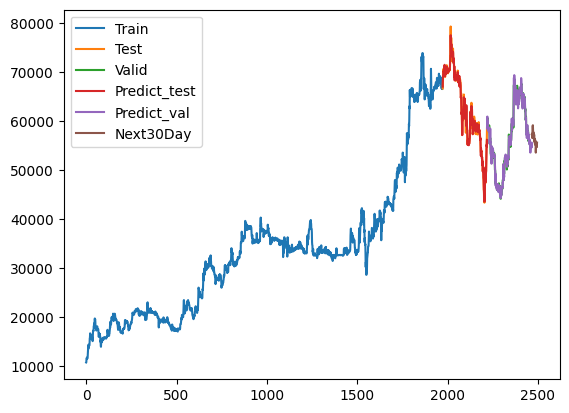

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()